In [345]:
import numpy as np
import matplotlib.pyplot as plt
import clustering as cl
import util
import healpy as hp
import importlib as imp
from collections import defaultdict
import seaborn as sns 


%matplotlib inline 

In [2]:
# Global parameters
gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

nside=8
n = -14
dt=15.0
cr=0.00124
pixels=range(hp.nside2npix(nside))

train_path = 'demo_train/UnnObs_Training_1_line_A_ec_labelled_2457308.5_pm15.0_r2.5.trans'
itf_path = 'demo_itf/itf_new_1_line_ec_2457308.5_pm15.0_r2.5.trans'


In [307]:
# cl.generate_sky_region_files('ryan_data_itf/itf_new_1_line_ec_2457308.5_pm15.0_r2.5.trans', pixels, nside, n)

In [9]:
true_count_set, mergedCounter_dict, mergedTime_dict = cl.accessible_clusters(pixels, infilename=train_path)
true_count = len(true_count_set)
print('True count of clusters: {}'.format(true_count))

right, wrong, ids_right, ids_wrong = cl.test_clusters(pixels, train_path, util.lunation_center(n), \
                                                    dt=dt,rad=cr)

print('Using our optimal parameters we got {0} percent of clusters with {1} percent errors.'.format(right/true_count,wrong/true_count))
print('We got',right,'right and',wrong,'wrong out of total',true_count)

True count of clusters: 890
Starting run...
100%

Run finished!
Using our optimal parameters we got 0.7842696629213484 percent of clusters with 0.0056179775280898875 percent errors.
We got 698 right and 5 wrong out of total 890


In [18]:
tr_results, tr_clust_ids = cl.find_clusters([281], train_path, util.lunation_center(n), g_gdots=g_gdots,dt=dt,rad=cr)

Starting run...
100%

Run finished!


In [41]:
# tr_clust_ids

In [198]:
cl = imp.reload(cl)
res_dict = cl.get_res_dict(train_path,[281],nside,n)

In [229]:
agg_dict = defaultdict(list)
for k,v in tr_clust_ids.items():
    # k is the tracklet id, v is the cluster id 
    agg_dict[v].append([tuple([k]+list(i)) for i in res_dict[k]])

In [231]:
# agg_dict
# 

In [ ]:
g,gdot = 0.4,0.0
results = []
for k, v in agg_dict.items():
    cx, mx, cy, my, t0 = full_fit_trkl(t_ref, g, gdot, v)
    result = (k, cx, mx, cy, my, t0)
    results.append(result)



In [315]:
po = []
for k,v in agg_dict.items():
    if v!=[]:
        po.append(k)
np.array(po)

array([1052, 1050,   43,  443,  245,  122, 1123,   69,  273, 1113,  487,
        730,  682,  733,  713,  798,  664,  130,  195,  770,  723,  767,
        735,  193,  842,  161,  734, 1275, 1360,  494,  332, 1571, 1362,
        855,  794,  440,  302,  190,  314, 1114,  345,  416,  241,  512,
        260,  525,  499,  434,  361,  428,  331,  530,  274,  488, 1276,
        848, 1595,  853,  385,  306,  394,  445,  469,  478,  337,  412,
       1662,  352,  433,  526,  360,  442,  362,  438,  517,  439,  858,
        389, 1599,  497,  441, 1714,  492, 1726,  571,  700,  629,  679,
        787,  584,  658,  778,  681,  570,  701,  876,  625,   54,  726,
        824,  732,  757,  668,  561,  674,  667,  724,  631,  656,  677,
        623,  638,  659,  662,  646,  670, 2540,  651,  714,  805,  808,
       2555, 2581, 2588,  725,  706,  729,  708,  812,  809,  665,  731,
        775,  727,  758,  820,  834,  883,  799,  765,  769,  837, 1472,
       1273,  854,  911,  373,  983, 1030, 1009, 13

In [253]:
a_obs3 = [itm for ob in agg_dict[1052] for itm in ob]
# [i[0] for i in a_obs3])
sorted([(i[0],i[1]) for i in a_obs3],key=lambda x: x[1])

[('K13CI6G_018', 2457312.746549),
 ('K13CI6G_018', 2457312.752789),
 ('K13CI6G_018', 2457312.763969),
 ('K13CI6G_018', 2457312.768859),
 ('K13CI6G_018', 2457312.773669),
 ('K13CI6G_019', 2457314.750439),
 ('K13CI6G_019', 2457314.756469),
 ('K13CI6G_019', 2457314.761319),
 ('K13CI6G_019', 2457314.766039),
 ('K13CI6G_019', 2457314.770859),
 ('K13CI6G_020', 2457316.858239),
 ('K13CI6G_020', 2457316.869239),
 ('K13CI6G_020', 2457316.880229),
 ('K13CI6G_020', 2457316.891239)]

In [37]:
print('We have {} observations in cluster id 3'.format(len(a_obs3)))

We have 16 observations in cluster id 3


In [91]:
from scipy.optimize import curve_fit
def getXval():
    a = 4; b = 3; c = 1;
    f0 = a*b**2*c
    f1 = a*b/c
    return np.array([f0, f1])

def fit(x, a0, a1):
    res = a0*x[0] + a1*x[1]
    return np.array([res])

x = getXval()
y = np.array([0.15, 0.34])
popt, pcov = curve_fit(fit, x, y)
print(popt, pcov)

[-0.32652778  1.        ] [[ inf  inf]
 [ inf  inf]]


/Users/paulblankley/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [300]:
g,gdot = 0.4,0.0
idx = 1052
cl = imp.reload(cl)
params, loss_val, chisq, chisq_arr = cl.full_fit_t_loss(util.lunation_center(n), g, gdot, agg_dict[idx])

Avg reference time: 2457314.6507075713
init [-0.04021425  0.00452398 -0.07850673 -0.00099668  0.4         0.        ]
diff [0.022333485375738839, 0.00073824535097452787, 0.0090990351869454922, 0.00046239809013203133, 0.021121540670667183, 0.0027938034883624955]
everything       fun: 1.5383269050734907e-10
 hess_inv: array([[  1.21634421e-01,  -3.54864358e-01,   5.94293953e-02,
         -4.40067465e-01,   5.22756850e-01,   3.14227272e+00],
       [ -3.54864358e-01,   2.77697995e+00,  -2.09716773e-01,
          3.37165465e+00,  -2.24029936e+00,  -2.41106345e+01],
       [  5.94293953e-02,  -2.09716773e-01,   4.67195305e-02,
         -2.58992546e-01,   2.93437521e-01,   1.85083349e+00],
       [ -4.40067465e-01,   3.37165465e+00,  -2.58992546e-01,
          4.10742475e+00,  -2.75549828e+00,  -2.93352292e+01],
       [  5.22756850e-01,  -2.24029936e+00,   2.93437521e-01,
         -2.75549828e+00,   2.70243395e+00,   1.96887960e+01],
       [  3.14227272e+00,  -2.41106345e+01,   1.85083349e

In [301]:
chisq

162.60746341021454

In [302]:
util.lunation_center(-14)

2457308.5

In [303]:
a_obs = [ob for trkl in agg_dict[idx] for ob in trkl]
[(ob[0],ob[1],ch) for ob,ch in zip(a_obs,chisq_arr)]

[('K13CI6G_020', 2457316.858239, 1.0616507838435021),
 ('K13CI6G_020', 2457316.869239, 3.0435943296340371),
 ('K13CI6G_020', 2457316.880229, 13.257881544457085),
 ('K13CI6G_020', 2457316.891239, 13.862686759460184),
 ('K13CI6G_019', 2457314.750439, 22.599695682679034),
 ('K13CI6G_019', 2457314.756469, 11.574690019297119),
 ('K13CI6G_019', 2457314.761319, 11.230517489666772),
 ('K13CI6G_019', 2457314.766039, 29.293761828592512),
 ('K13CI6G_019', 2457314.770859, 19.223802692687457),
 ('K13CI6G_018', 2457312.746549, 3.5152703301209791),
 ('K13CI6G_018', 2457312.752789, 6.019131773639212),
 ('K13CI6G_018', 2457312.763969, 7.1172235746534387),
 ('K13CI6G_018', 2457312.768859, 17.668164803687581),
 ('K13CI6G_018', 2457312.773669, 3.1393917977956316)]

In [313]:
agg_dict[12]

[]

In [366]:
cl = imp.reload(cl)
par_results,chi_res  = {},[]
g,gdot = 0.4,0.0
idxs = [1052,443,1815,560,776,2449]
for idx in po:
    all_res = cl.full_fit_t_loss(util.lunation_center(n), g, gdot, agg_dict[idx])
    par_results[idx] = all_res[0]
    chi_res.append(all_res[2])

/Users/paulblankley/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


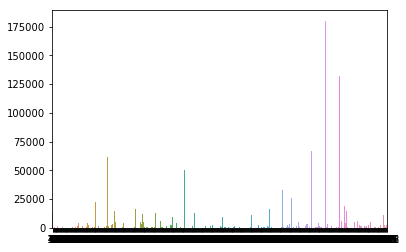

In [357]:
# del_idx = chi_res.index(max(chi_res))
# del chi_res[del_idx]
# del po[del_idx]

sns.barplot(po,chi_res)

# sorted(chi_res,reverse=True)


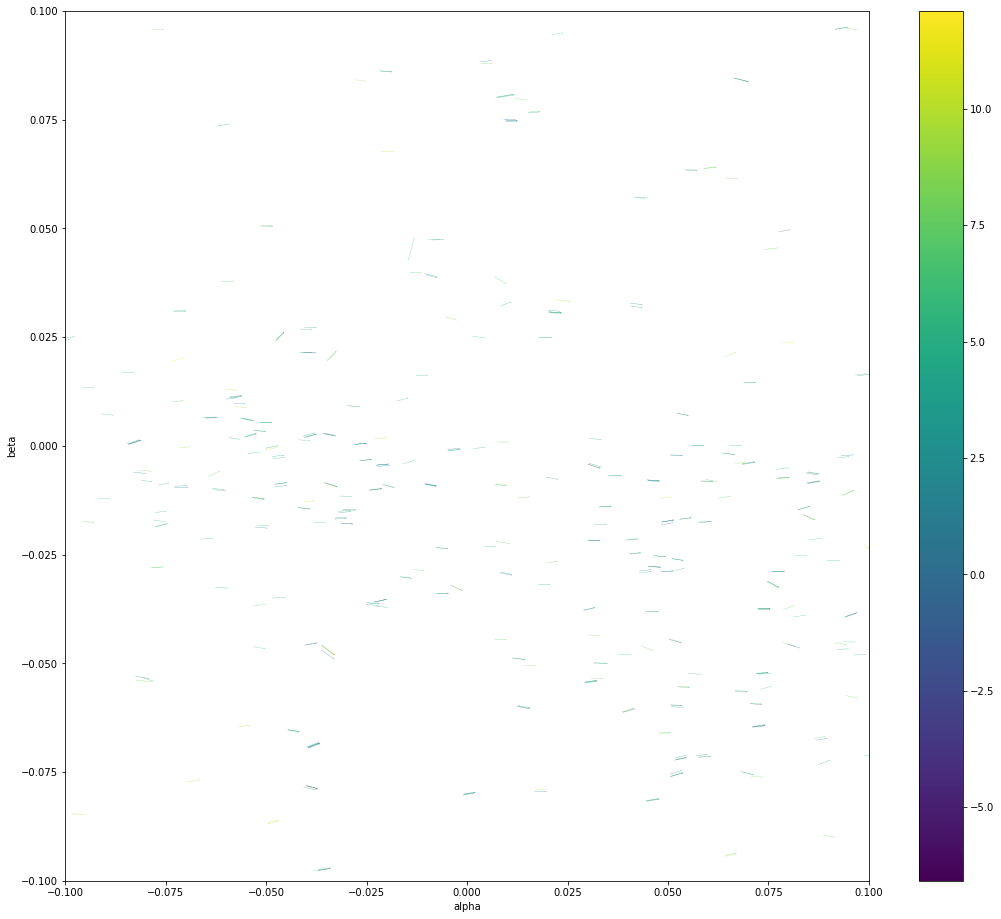

In [367]:
cl = imp.reload(cl)
cl.vis_arrows_by_chi(par_results,chi_res)

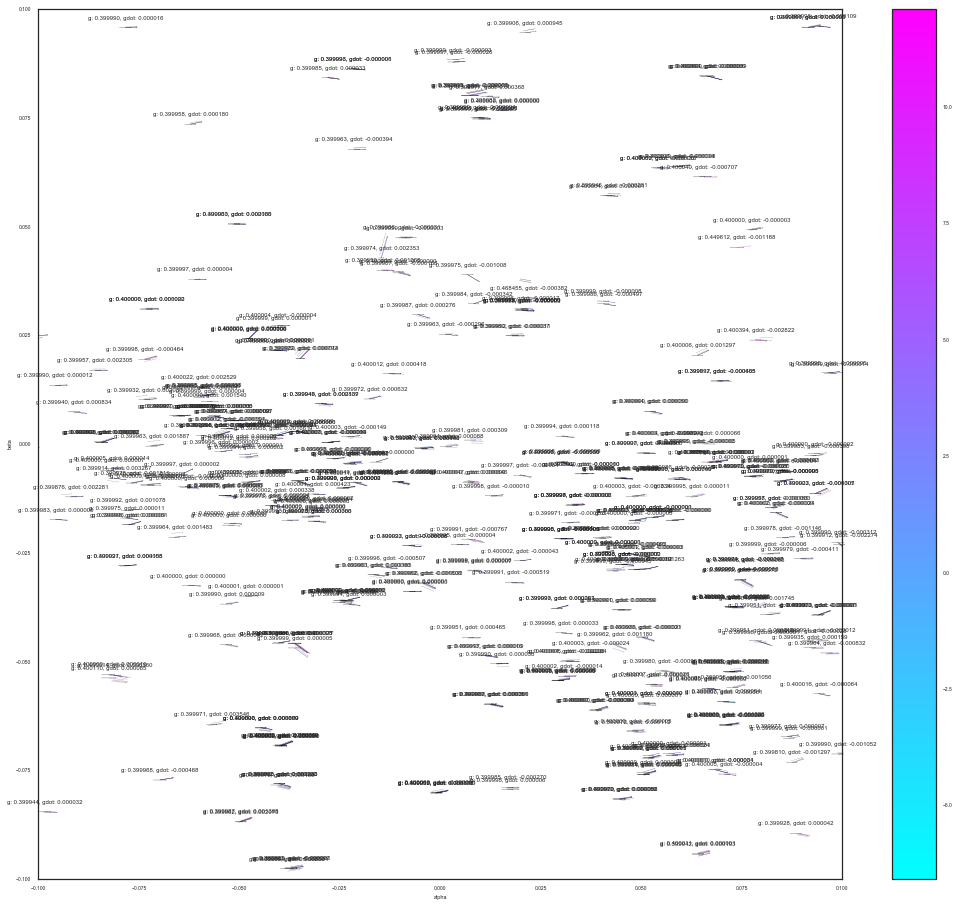

In [398]:
cl = imp.reload(cl)
sns.set(font_scale=.5)
sns.set_style('white')
ggdots = cl.vis_arrows_by_chi_with_trkl(par_results,agg_dict,po,util.lunation_center(n),chi_res)

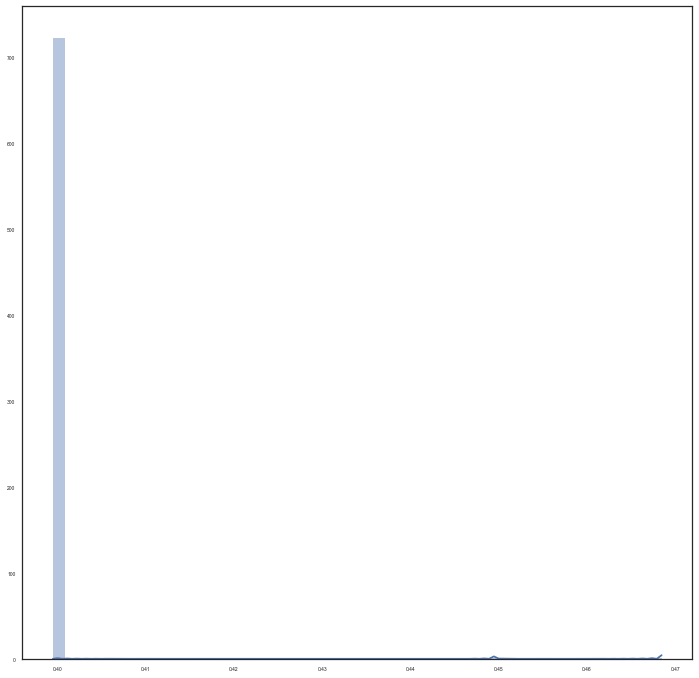

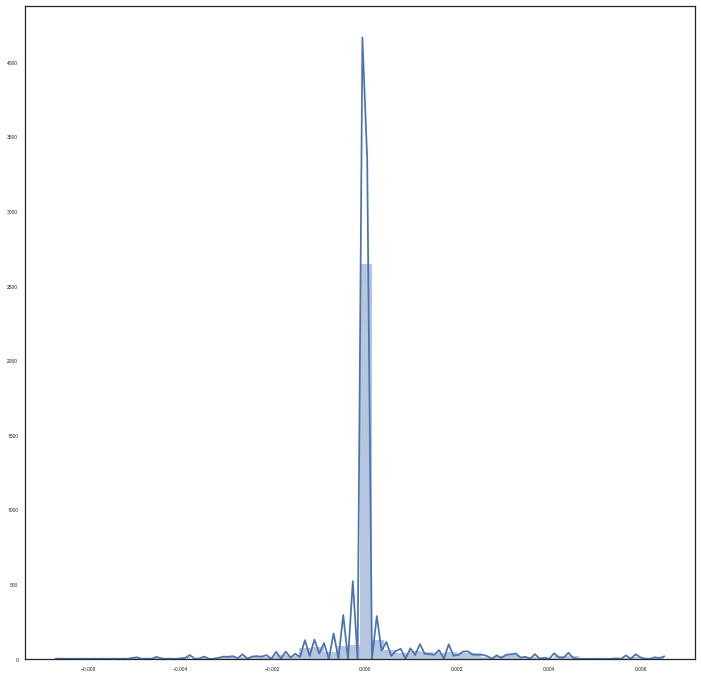

In [401]:
gd_dist = [i[1][0] for i in ggdots]
gdd_dist = [i[1][1] for i in ggdots]
fig,ax = plt.subplots(figsize=(12,12))
sns.distplot(gd_dist)
plt.title()
plt.show()
fig,ax = plt.subplots(figsize=(12,12))
sns.distplot(gdd_dist)


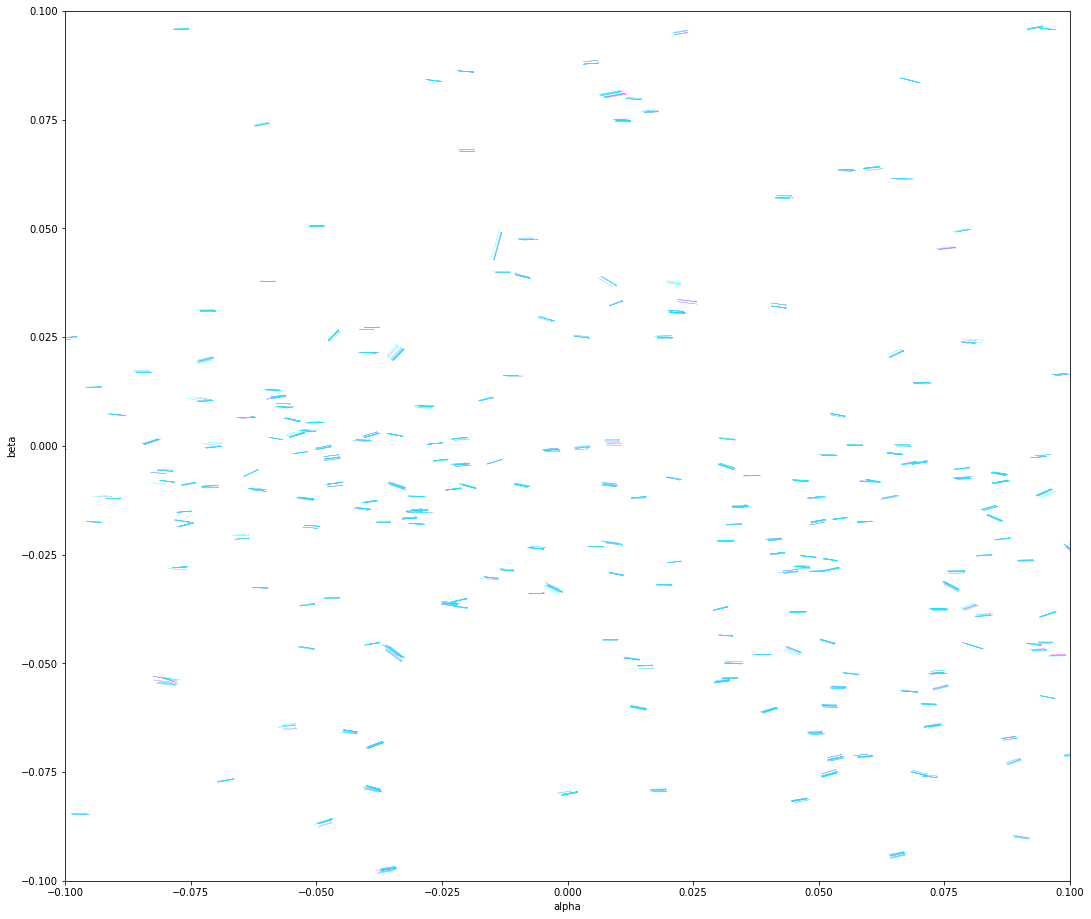

In [344]:
cl = imp.reload(cl)
cl.visualize(par_results,agg_dict,po,util.lunation_center(n))

In [193]:
g,gdot = 0.4,0.0
cl = imp.reload(cl)
# par3 = cl.full_fit_trkl(util.lunation_center(n),g,gdot,a_obs3)

In [197]:
chisq

0.012003235835689517

In [195]:
def fun(a):
    b=1
    global chi
    chi = 0.0
    def fr(a,b):
    
        chi= a+b/2.0*112.2
        print(chi)
        return a+b
    fr(a,b)
    print(chi)
    return a/b+2.

fun(3)

59.1
0.0


5.0